# Support Vector Regression
A continución se desarrolla un ejemplo usando Support Vector Regression en la data Boston que se uso durante la clase

1.Se importan las librerías que vamos a usar durante el ejemplo

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
dfboston = pd.read_csv("Boston.csv")
dfboston = dfboston.drop('Unnamed: 0', axis=1)
dfboston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Describimos el dataset, para saber si existen datos perdidos, variables con tipo de dato texto

In [3]:
dfboston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


Conociendo la correlación entre las variables

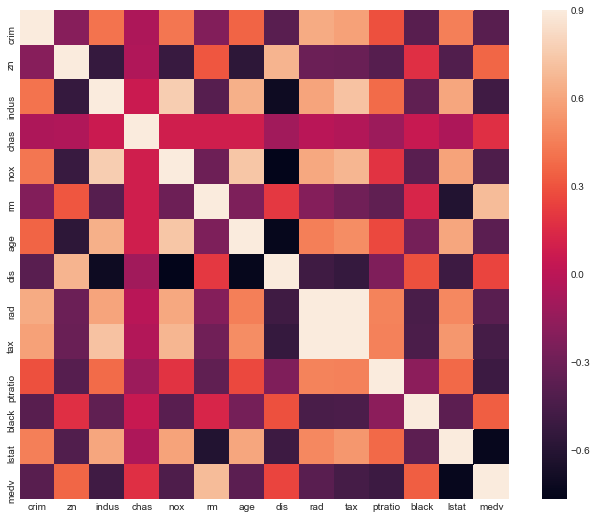

In [4]:
corrmat = dfboston.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Seteando las variables

In [5]:
predictors = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
target = dfboston['medv']

Usaremos el 80% de los datos para entrenar el modelo y el otro 20% para validación

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfboston, target, test_size=0.2)

Función para lanzar distintos modelos y obtener sus evaluaciones

In [7]:
def launch_model(name,model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train[predictors], y_train)
    y_pred = model.predict(X_test[predictors])
    ypred_train = model.predict(X_train[predictors])
    print ('MSE train', mean_absolute_error(y_train, ypred_train))
    print ('MSE test', mean_absolute_error(y_test, y_pred))
    r_2 = model.score(X_test[predictors], y_test)
    print ('R^2 test', r_2)
    print('Tiempo de ejecución: {0:.2f} segundos.'.format(time.time() - start))
    return name + '($R^2={:.3f}$)'.format(r_2), np.array(y_test), y_pred

In [8]:
def plot(results):
    '''
    Create a plot comparing multiple learners.
    `results` is a list of tuples containing:
        (title, expected values, actual values)
    
    All the elements in results will be plotted.
    '''

    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(8, 8))
    fig.canvas.set_window_title('Predicting Boston')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('Precio casa')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted')
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()

    # ==================================
    # Display the plot in interactive UI
    plt.show()

    # To save the plot to an image file, use savefig()
    plt.savefig('plot.png')

    # Open the image file with the default image viewer
    #import subprocess
    #subprocess.Popen('plot.png', shell=True)

    # To save the plot to an image in memory, use BytesIO and savefig()
    # This can then be written to any stream-like object, such as a
    # file or HTTP response.
    #from io import BytesIO
    #img_stream = BytesIO()
    #plt.savefig(img_stream, fmt='png')
    #img_bytes = img_stream.getvalue()
    #print('Image is {} bytes - {!r}'.format(len(img_bytes), img_bytes[:8] + b'...'))

    # Closing the figure allows matplotlib to release the memory used.
    plt.close()



Para nuestra evalución se harán comparaciones de 3 modelos:

1. Support vector regression con kernel RBF 
2. Support vector regression con kernel lineal
3. Regresion lineal clásica

In [9]:
svr_rbf = SVR(kernel='rbf', gamma=0.1)
svr_lineal = SVR(kernel='linear')
lr = LinearRegression()

In [10]:
results = []
print ('-----------')
print ('SVR - RBF')
print ('-----------')
results.append(launch_model('SVR - RBF', svr_rbf, X_train, y_train, X_test, y_test))
print ('-----------')
print ('SVR - lineal')
print ('-----------')
results.append(launch_model('SVR - lineal', svr_lineal, X_train, y_train, X_test, y_test))
print ('-----------')
print ('Regresion lineal')
print ('-----------')
results.append(launch_model('Regresion lineal', lr, X_train, y_train, X_test, y_test))

-----------
SVR - RBF
-----------
MSE train 5.540663317378831
MSE test 6.278798000299969
R^2 test -0.029581730000340922
Tiempo de ejecución: 0.03 segundos.
-----------
SVR - lineal
-----------
MSE train 3.2364863750113138
MSE test 2.7499870227630385
R^2 test 0.7987430729563638
Tiempo de ejecución: 3.27 segundos.
-----------
Regresion lineal
-----------
MSE train 3.4263864064961074
MSE test 3.020260235157817
R^2 test 0.7665609834711722
Tiempo de ejecución: 0.01 segundos.


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


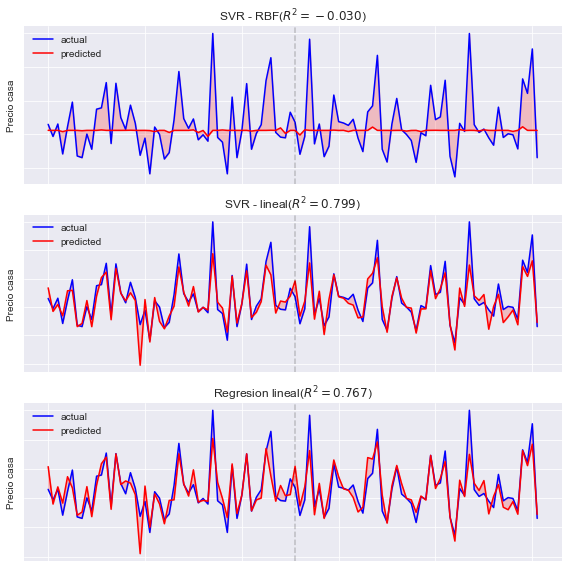

In [11]:
plot(results)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[predictors])
X_train[predictors] = scaler.transform(X_train[predictors])
X_test[predictors] = scaler.transform(X_test[predictors])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [13]:
results = []
print ('-----------')
print ('SVR - RBF')
print ('-----------')
results.append(launch_model('SVR - RBF', svr_rbf, X_train, y_train, X_test, y_test))
print ('-----------')
print ('SVR - lineal')
print ('-----------')
results.append(launch_model('SVR - lineal', svr_lineal, X_train, y_train, X_test, y_test))
print ('-----------')
print ('Regresion lineal')
print ('-----------')
results.append(launch_model('Regresion lineal', lr, X_train, y_train, X_test, y_test))

-----------
SVR - RBF
-----------
MSE train 3.135666425461508
MSE test 2.6841302011616395
R^2 test 0.7688288219832762
Tiempo de ejecución: 0.03 segundos.
-----------
SVR - lineal
-----------
MSE train 3.2144343081427493
MSE test 2.6506786103529847
R^2 test 0.8095379663593361
Tiempo de ejecución: 0.03 segundos.
-----------
Regresion lineal
-----------
MSE train 3.4263864064961074
MSE test 3.0202602351577807
R^2 test 0.7665609834711768
Tiempo de ejecución: 0.01 segundos.


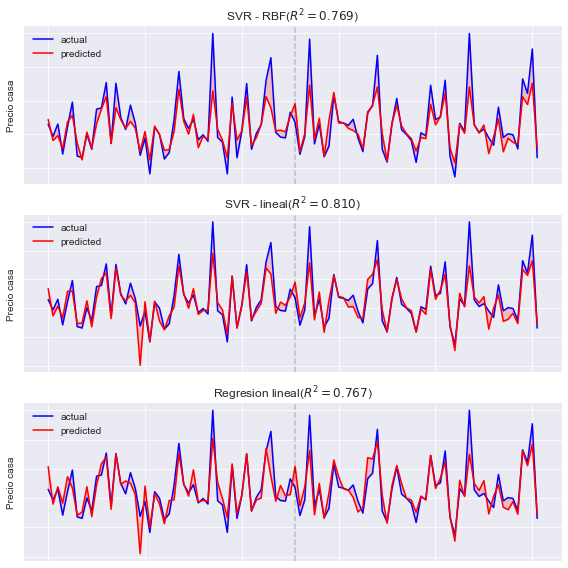

In [14]:
plot(results)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 22.53 and sigma = 9.19



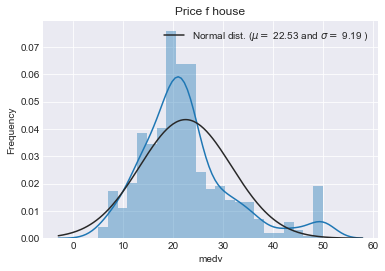

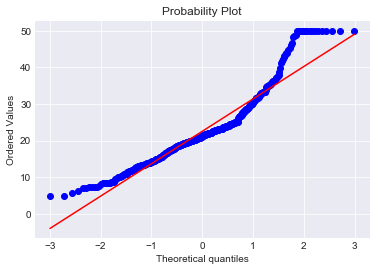

In [15]:
sns.distplot(target , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price f house')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 3.09 and sigma = 0.39



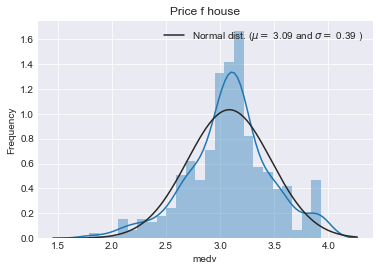

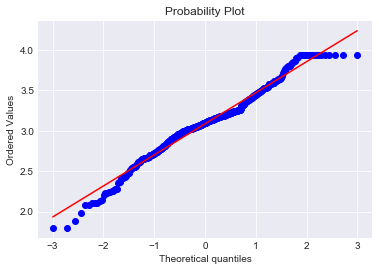

In [16]:
target = np.log1p(target)

sns.distplot(target , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price f house')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dfboston, target, test_size=0.2)

In [18]:
def launch_model(name,model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train[predictors], y_train)
    y_pred = model.predict(X_test[predictors])
    ypred_train = model.predict(X_train[predictors])
    print ('MSE train', mean_absolute_error(np.expm1(y_train), np.expm1(ypred_train)))
    print ('MSE test', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))
    r_2 = model.score(X_test[predictors], y_test)
    print ('R^2 test', r_2)
    print('Tiempo de ejecución: {0:.2f} segundos.'.format(time.time() - start))
    return name + '($R^2={:.3f}$)'.format(r_2), np.expm1(np.array(y_test)), np.expm1(y_pred)

In [19]:
results = []
print ('-----------')
print ('SVR - RBF')
print ('-----------')
results.append(launch_model('SVR - RBF', svr_rbf, X_train, y_train, X_test, y_test))
print ('-----------')
print ('SVR - lineal')
print ('-----------')
results.append(launch_model('SVR - lineal', svr_lineal, X_train, y_train, X_test, y_test))
print ('-----------')
print ('Regresion lineal')
print ('-----------')
results.append(launch_model('Regresion lineal', lr, X_train, y_train, X_test, y_test))

-----------
SVR - RBF
-----------
MSE train 1.980589918544873
MSE test 6.004191081116201
R^2 test 0.08160837957704137
Tiempo de ejecución: 0.02 segundos.
-----------
SVR - lineal
-----------
MSE train 2.635716589380669
MSE test 3.013843134776298
R^2 test 0.6386593303206323
Tiempo de ejecución: 18.29 segundos.
-----------
Regresion lineal
-----------
MSE train 2.781861571719489
MSE test 2.9325658255617975
R^2 test 0.6963016737656056
Tiempo de ejecución: 0.01 segundos.


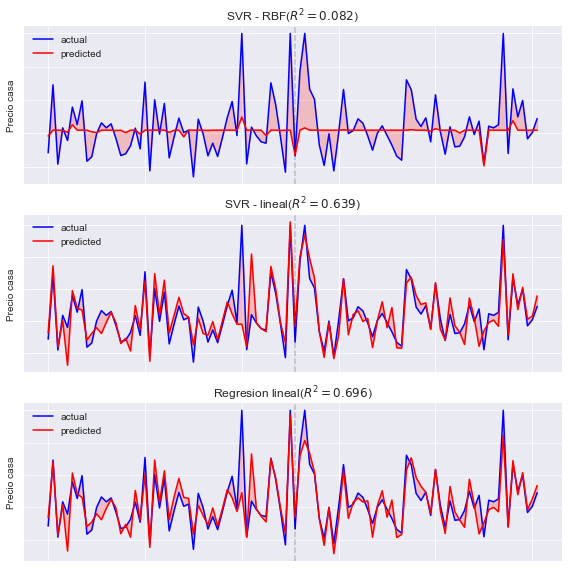

In [20]:
plot(results)